# Image processing pipeline on representative bone marrow sample

This notebook gives an overview of all steps of the image processing pipeline applied to one representative bone marrow sample. 

## Loading multiplex IF and IMC images

First, we read the raw 3-plex IF and 44-plex (including calibration channels) IMC images. The nomenclature of the files is essential and should be as follows:
- sample folder: staining_data_IMC_date_sample_ID_tissue_type
- IF image: staining_data_IMC_date_sample_ID_tissue_type_image_number_channel.TIF
- IMC image: staining_data_IMC_date_sample_ID_tissue_type.mcd

Large IF images were generated (roughly 9,000 x 9,000 px) to account for the offset between IF and IMC measurements. IMC images have an initial size of 700 x 700 px, but are cropped by 2 pixel to eliminate ablation artifacts on image borders yielding a final size of 696 x 696 pixels. 

In [2]:
from MapMetIP.src.sample import MapMetIP_Sample
from pathlib import Path
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

base = Path("../test_data/BM")
sample_name = "20220727_20220222_16-4503_BM"

sample_folder = base.joinpath("data", sample_name)
sample = MapMetIP_Sample(sample_folder)

#select ROI for demonstration
roi=1 

IF = sample.mod0[roi]
IMC = sample.mod1[roi]

clear_output()
print("The", IF.image_stack.shape[0],"- plex IF images have a size of ",IF.image_stack.shape[1]," x " ,IF.image_stack.shape[2]," px.")
print("The", IMC.image_stack.shape[0],"- plex IMC images have a size of ",IMC.image_stack.shape[1]," x " ,IMC.image_stack.shape[2]," px.")


The 3 - plex IF images have a size of  8704  x  9728  px.
The 44 - plex IMC images have a size of  696  x  696  px.


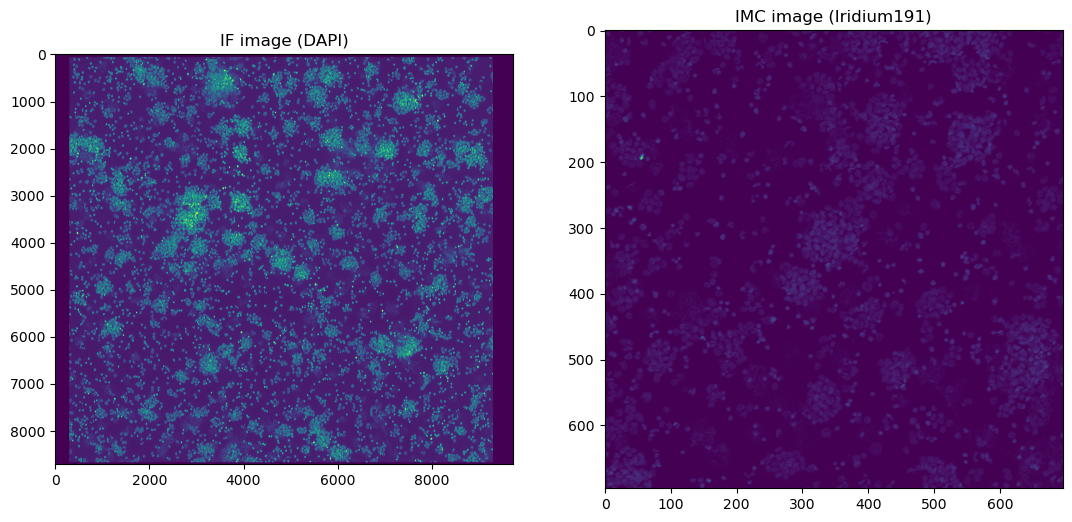

In [3]:
#select IF (mod0) channel to visualize
channel_IF="IF1_DAPI"

#select IMC (mod1) channel to visualize
channel_IMC="DNA1_Ir191"

#plot images
channel_idx = np.where(IF.stack_channels==channel_IF)[0][0]
IF_nuclear_image = IF.image_stack[channel_idx]

channel_idx = np.where(IMC.stack_channels==channel_IMC)[0][0]
IMC_image = IMC.image_stack[channel_idx]

fig, ax = plt.subplots(1, 2, figsize=(13, 13))
ax[0].imshow(IF_nuclear_image)
ax[1].imshow(IMC_image)

ax[0].set_title('IF image (DAPI)')
ax[1].set_title('IMC image (Iridium191)')

plt.show()

## Registration of IF and IMC image

We register the IF and IMC images based on the nuclear IF (DAPI) and nuclear IMC image, the latter being the mean of four nuclear markers (H3K9Ac, H4K12Ac, Ir191 and Ir193). 

In [4]:
# calculate nuclear IMC image based on mean of four nuclear markers.
sample.calculate_nuclear_image()
IMC_nuclear_image = IMC.nuclear_image[0]

Registration is performed based on scale-invariant feature transformation (**DOI**: 10.1109/ICCCNT.2012.6396024) as follows:

1. For the estimation of an affine transformation, images are pre-processed by 
    - hot-pixel removal
    - CLAHE-based histogram equalization and
    - clipping to the 1st and 99th percentile

2. For visualization and extraction of intensity features, we compute a transformation matrix from the larger, high-resolution IF to the smaller, low-resolution IMC image (``self.h_mov2fix``)
3. For segmentation and extraction of morphological features, we invert the determined transformation matrix to determine where to crop the IF-based segmentation mask (``self.h_fix2mov``)

In [5]:
from MapMetIP.src.register import Registerer

registerer = Registerer("SIFT")

registerer.register(
    mov=IF_nuclear_image.squeeze(), 
    fix=IMC_nuclear_image.squeeze(), 
    preprocessing=True)

print("Transformation matrix from IF to IMC: \n", registerer.h_mov2fix, "\n")
print("Transformation matrix from IMC to IF: \n", registerer.h_fix2mov)

Transformation matrix from IF to IMC: 
 [[-1.60381508e-04 -1.72141085e-01  1.09785435e+03]
 [ 1.72141085e-01 -1.60381508e-04 -5.12808899e+02]] 

Transformation matrix from IMC to IF: 
 [[-5.41233720e-03  5.80918340e+00  2.98494290e+03]
 [-5.80918340e+00 -5.41233720e-03  6.37486178e+03]]


The determined transformation matrices are then applied to the raw (non-processed) images.

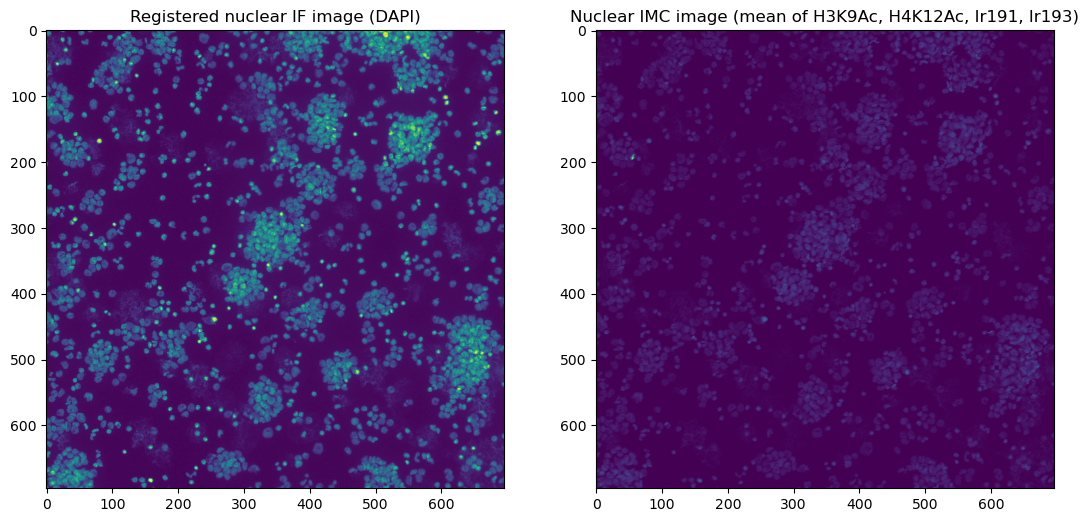

In [7]:
IF_registered = registerer.warp(IF.image_stack, IMC.nuclear_image.squeeze().shape, registerer.h_mov2fix)
IF_nuclear_registered = IF_registered[0]

fig, ax = plt.subplots(1, 2, figsize=(13, 13))
ax[0].imshow(IF_nuclear_registered)
ax[1].imshow(IMC_nuclear_image)

ax[0].set_title('Registered nuclear IF image (DAPI)')
ax[1].set_title('Nuclear IMC image (mean of H3K9Ac, H4K12Ac, Ir191, Ir193)')

plt.show()

## Segmentation based on nuclear IF image

For segmentation, we use our finetuned cellpose model on the high-resolution nuclear IF image. Cellpose requires the definition of an average nuclear diameter (``segmentation_diameter``) in pixels. For BM samples, which contain a high number of segmented nuclei (e.g. in neutrophils), we refine masks upon segmentation by zeroing the mask where the corresponding DAPI image falls below a defined threshold (``refine_threshold``). 

In [ ]:
from MapMetIP.src.segmentation import Segmenter
path2model = base.joinpath("segmentation_model", "CP_BM") #does not work-find out why
segmenter = Segmenter("/home/daria_l/src/MapMetIP/test_data/BM/segmentation_model/CP_BM")

segmentation_diameter = 55
refine_threshold = 0.12

segmentation_masks, refined_segmentation_masks = segmenter.segment(
    IF_nuclear_image.squeeze(), 
    eval_kwargs={"diameter": segmentation_diameter},
    refine_threshold=refine_threshold)

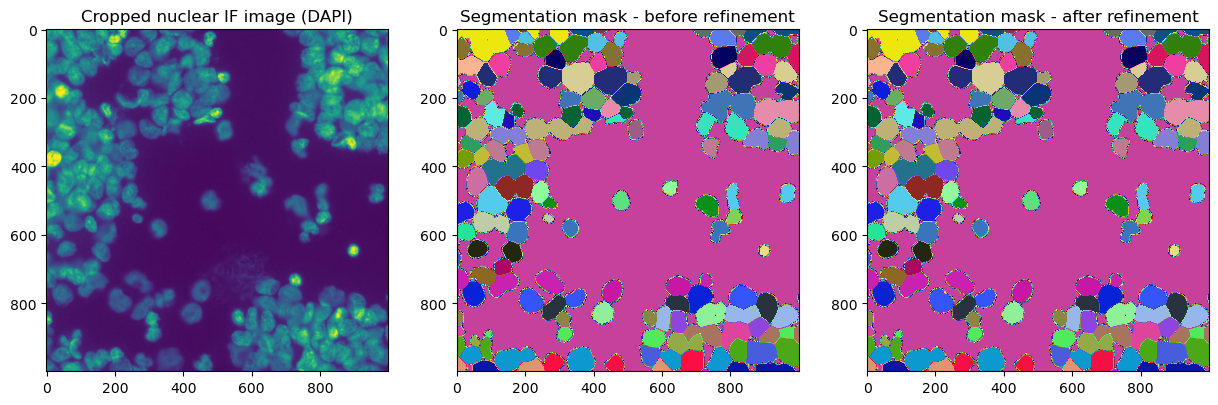

In [15]:
from matplotlib.colors import ListedColormap

IF_nuclear_image_zoom = IF_nuclear_image[3000:4000, 3000:4000]
segmentation_mask_zoom = segmentation_masks[3000:4000, 3000:4000]
refined_segmentation_mask_zoom = refined_segmentation_masks[3000:4000, 3000:4000]

cmap = ListedColormap(np.random.rand(256,3))

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(IF_nuclear_image_zoom)
ax[1].imshow(segmentation_mask_zoom, cmap=cmap)
ax[2].imshow(refined_segmentation_mask_zoom, cmap=cmap)

ax[0].set_title('Cropped nuclear IF image (DAPI)')
ax[1].set_title('Segmentation mask - before refinement')
ax[2].set_title('Segmentation mask - after refinement')

plt.show()

In [ ]:
""" small_segmentation_masks = registerer.warp(segmentation_masks, mod1.nuclear_image.squeeze().shape, registerer.h_mov2fix, interpolation=cv2.INTER_NEAREST)
small_refined_segmentation_masks = registerer.warp(refined_segmentation_masks, mod1.nuclear_image.squeeze().shape, registerer.h_mov2fix, interpolation=cv2.INTER_NEAREST)

registration_mapping = np.ones_like(mod1.nuclear_image)
large_mask = registerer.warp(registration_mapping, mod0.image_stack[mod0.stack_channels == "IF1_DAPI"].squeeze().shape, registerer.h_fix2mov)

idxs = np.where(large_mask != 0)
xmin, xmax = idxs[0].min(), idxs[0].max()
ymin, ymax = idxs[1].min(), idxs[1].max()
logger.debug(f"mapping idxs: {xmin}, {xmax}, {ymin}, {ymax}")

large_segmentation_masks = segmentation_masks[xmin:xmax, ymin:ymax]
large_refined_segmentation_masks = refined_segmentation_masks[xmin:xmax, ymin:ymax]

sample.mod0[roi].image_stack = mod0_stack
sample.mod1[roi].image_stack = mod1_stack

sample.data[roi] = {
    "large_segmentation_masks": large_segmentation_masks,
    "small_segmentation_masks": small_segmentation_masks, """